In [1]:
from unet import unet_constructor as GUnet
import dataloader as dataloader
from loss import dice_loss, cross_entropy_loss
import transforms as t

import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage.io as io
import os

writer = SummaryWriter()

In [2]:
data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(),
                                          t.random_crop([300, 300, 19]),
                                          t.random_rotate(),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          t.drop_channel(.75), 
                                          t.random_gamma((.8,1.2)),
                                          t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 19]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [3]:
device = 'cuda:0'

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             feature_sizes=[8,16,32,64,128],
             kernel={'conv1': (3, 3, 2), 'conv2': (3, 3, 1)},
             upsample_kernel=(2, 2, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1,
             groups=2).to(device)


test = test.type(torch.float)

image, mask, pwl = data[0]

out = test.forward(image.float().to(device))
out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))



In [4]:
test.load('apr23_2.unet')
test.cuda()
test.train()

unet_constructor(
  (out_conv): Conv3d(8, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (down_steps): ModuleList(
    (0): Down(
      (conv1): Conv3d(4, 8, kernel_size=(3, 3, 2), stride=(1, 1, 1), groups=2)
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 1), stride=(1, 1, 1), groups=2)
      (batch1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Down(
      (conv1): Conv3d(8, 16, kernel_size=(3, 3, 2), stride=(1, 1, 1), groups=2)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 1), stride=(1, 1, 1), groups=2)
      (batch1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Down(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 2), stride=(1, 1, 1), groups=2)
     

In [9]:
epoch = 0 
k = 0
running_loss = 0
device = 'cuda:0'

losses_dice=[]
avg_losses_dice = []
losses_BCE=[]
avg_losses_BCE = []



In [20]:
lr = 0.1
gamma = .75

optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=1e-3, momentum=.8, nesterov=True)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [ ]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]

        optimizer.zero_grad()
        out = test(image.float().to('cuda'))

        if k == 0:
            out_loss = dice_loss(out, mask.to('cuda'))
            losses_dice.append(out_loss.item())
            epoch_loss_dice.append(out_loss.item())
            k = 0
        else: 
            out_loss = cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'))
            losses_BCE.append(out_loss.item())
            k = 0



        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        if k == 0:
            print(f' DICE |',end='')
        else:
            print(' BCE |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        if epoch > 10 and k == 0:
            avg_losses_dice.append(np.array(losses_dice[-30::1]).sum()/len(losses_dice[-30::1]))
        #    print(f' | \033[31mAL: \033[0m{str(avg_losses_dice[-1])[0:8]}',end='')
        elif epoch > 10:
            avg_losses_BCE.append(np.array(losses_BCE[-30::1]).sum()/len(losses_BCE[-30::1]))
        #    print(f' | \033[31mAL: \033[0m{str(avg_losses_BCE[-1])[0:8]}',end='')
        
        if epoch > 10:
            print(f' | \033[31mAL DICE: \033[0m{str(avg_losses_dice[-1])[0:8]}',end='')
            #print(f'  \033[31mAL BCE: \033[0m{str(avg_losses_BCE[-1])[0:8]}',end='')


        out_loss.backward()
        optimizer.step()

        running_loss = out_loss.item()

        if epoch+1 % 150 == 0:
            scheduler_1.step() 
            writer.add_scalar('Learning Rate', lr, epoch)
            lr *= gamma


    #After Epoch has run    
    to_tb = (np.array(epoch_loss_dice).sum()/len(epoch_loss_dice))
    writer.add_scalar('Dice Loss Train',to_tb, epoch)
    epoch += 1





Epoch: 839 | DICE | POL: 0.560386 --> OL: 0.838737 | AL DICE: 0.614999

In [ ]:
epoch_loss_dice

In [ ]:
test.save('apr23_2.unet')

In [ ]:
plt.semilogy(avg_losses_dice[10::])

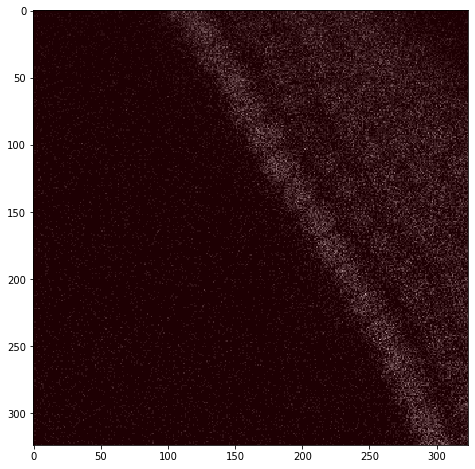

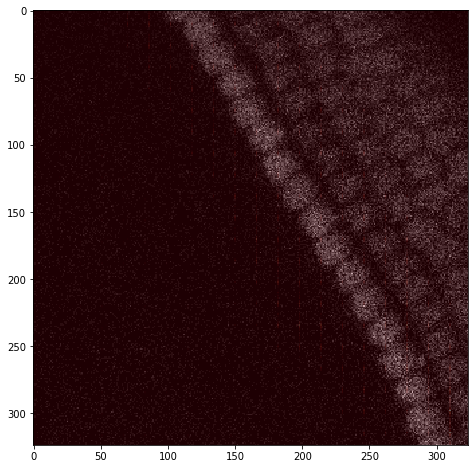

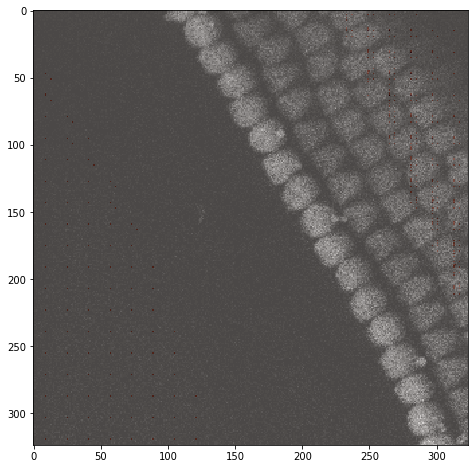

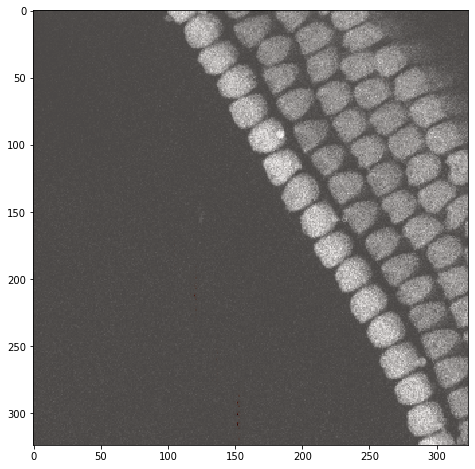

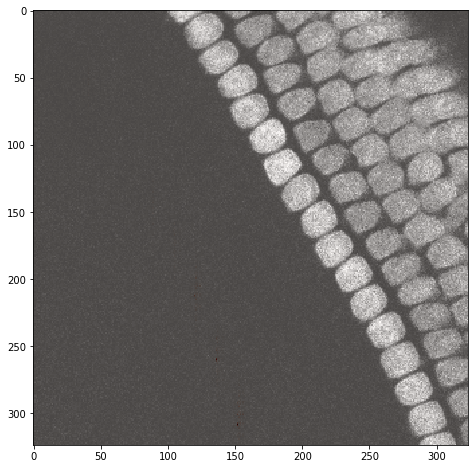

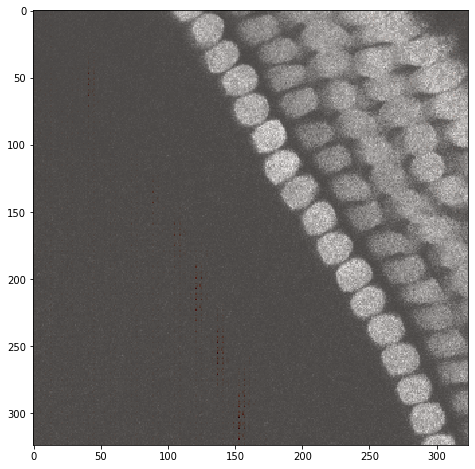

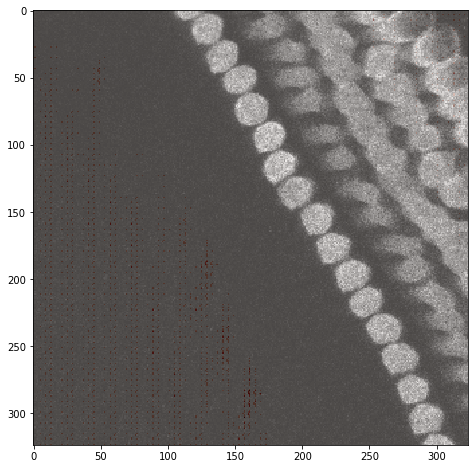

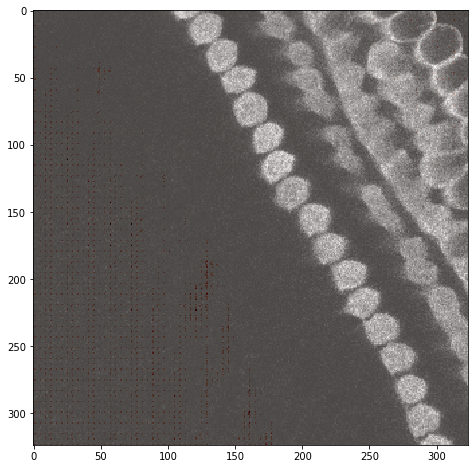

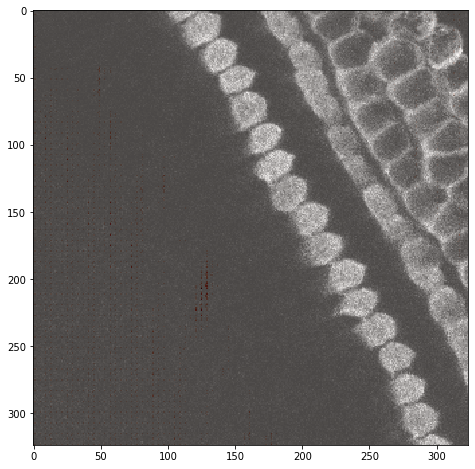

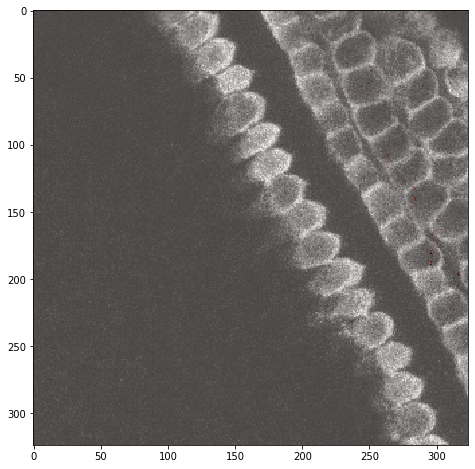

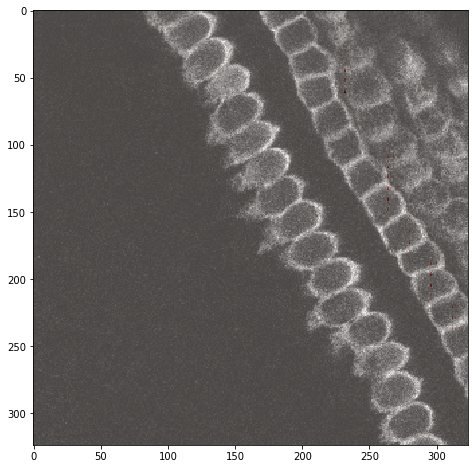

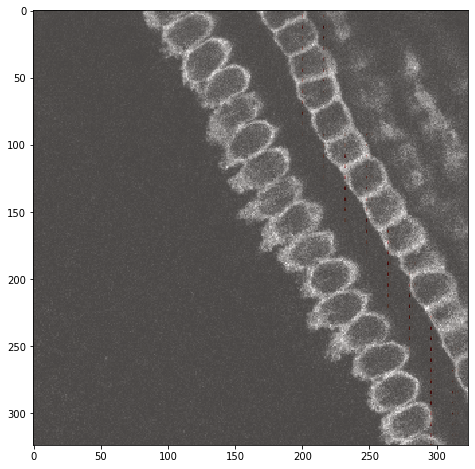

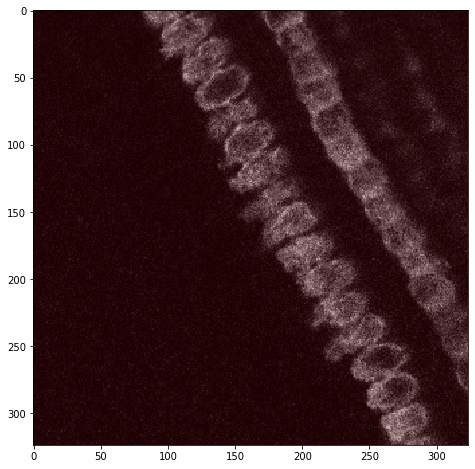

In [16]:
image, mask, pwl  = val_data[0]
        # forward + backward + optimize

out = test(image.float().to('cuda'))

mask = torch.sigmoid(out).to('cpu').squeeze(0).detach().transpose(0,3).numpy() 

for i in range(13):
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.imshow(image[0,2,:,:,i],cmap='Greys_r')
    ax.imshow(mask[i,:,:,0],cmap='Reds_r',alpha=.3)
    plt.show()

In [18]:
mask.min()

0.0002686065